In [1]:
import sys
# import numpy as np
# import matplotlib.pyplot as plt
import pandas as pd
# import lightkurve as lk
# from scipy.optimize import curve_fit

# from astropy.convolution import Gaussian1DKernel
# from astropy.convolution import convolve
sys.path.insert(0, "../")

from michael import janet

Hi there. Welcome to the good place.


In [2]:
uni = pd.read_csv("/Users/oliver hall/Research/unicorn/data/unicorn.csv", index_col=0)

Index 258 is a good tester. Clear rotational signal, ambiguous peak mode.

In [3]:
j = janet.boot(uni, index=58)

Already have data downloaded for Gaia ID 5317085678997964416.
If you want to check for new data, run `janet.update()`.
No postcard object will be created for this target.
No postcard object will be created for this target.
### Running Simple Astropy Lomb-Scargle on Sector 8 on star 5317085678997964416 ###
### Completed Simple Astropy Lomb-Scargle for Sector 8 on star 5317085678997964416 ###
### Saved results ###
### Running Simple Astropy Lomb-Scargle on Sector 10 on star 5317085678997964416 ###
### Completed Simple Astropy Lomb-Scargle for Sector 10 on star 5317085678997964416 ###
### Saved results ###
### Running Wavelet Estimation on star 5317085678997964416 ###


/Users/Anaconda/anaconda3/lib/python3.8/site-packages/jazzhands/wavelets.py:488: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm



### Completed Wavelet Estimation on star 5317085678997964416 ###
### Saved results ###
### Running ACF Estimation on star 5317085678997964416 ###
### Completed ACF Estimation on star 5317085678997964416 ###
### Saved results ###
### Saved results ###
### Saved results ###
### Saved results ###
### Saved results ###

------ Decoding Overall Period Flag 129 ------
128: The ACF period does not match the 'best' period within 2 sigma.
1: Best rotation is from the Simple Lomb Scargle (SLS) method.

No other flags raised. 

### Saved results ###


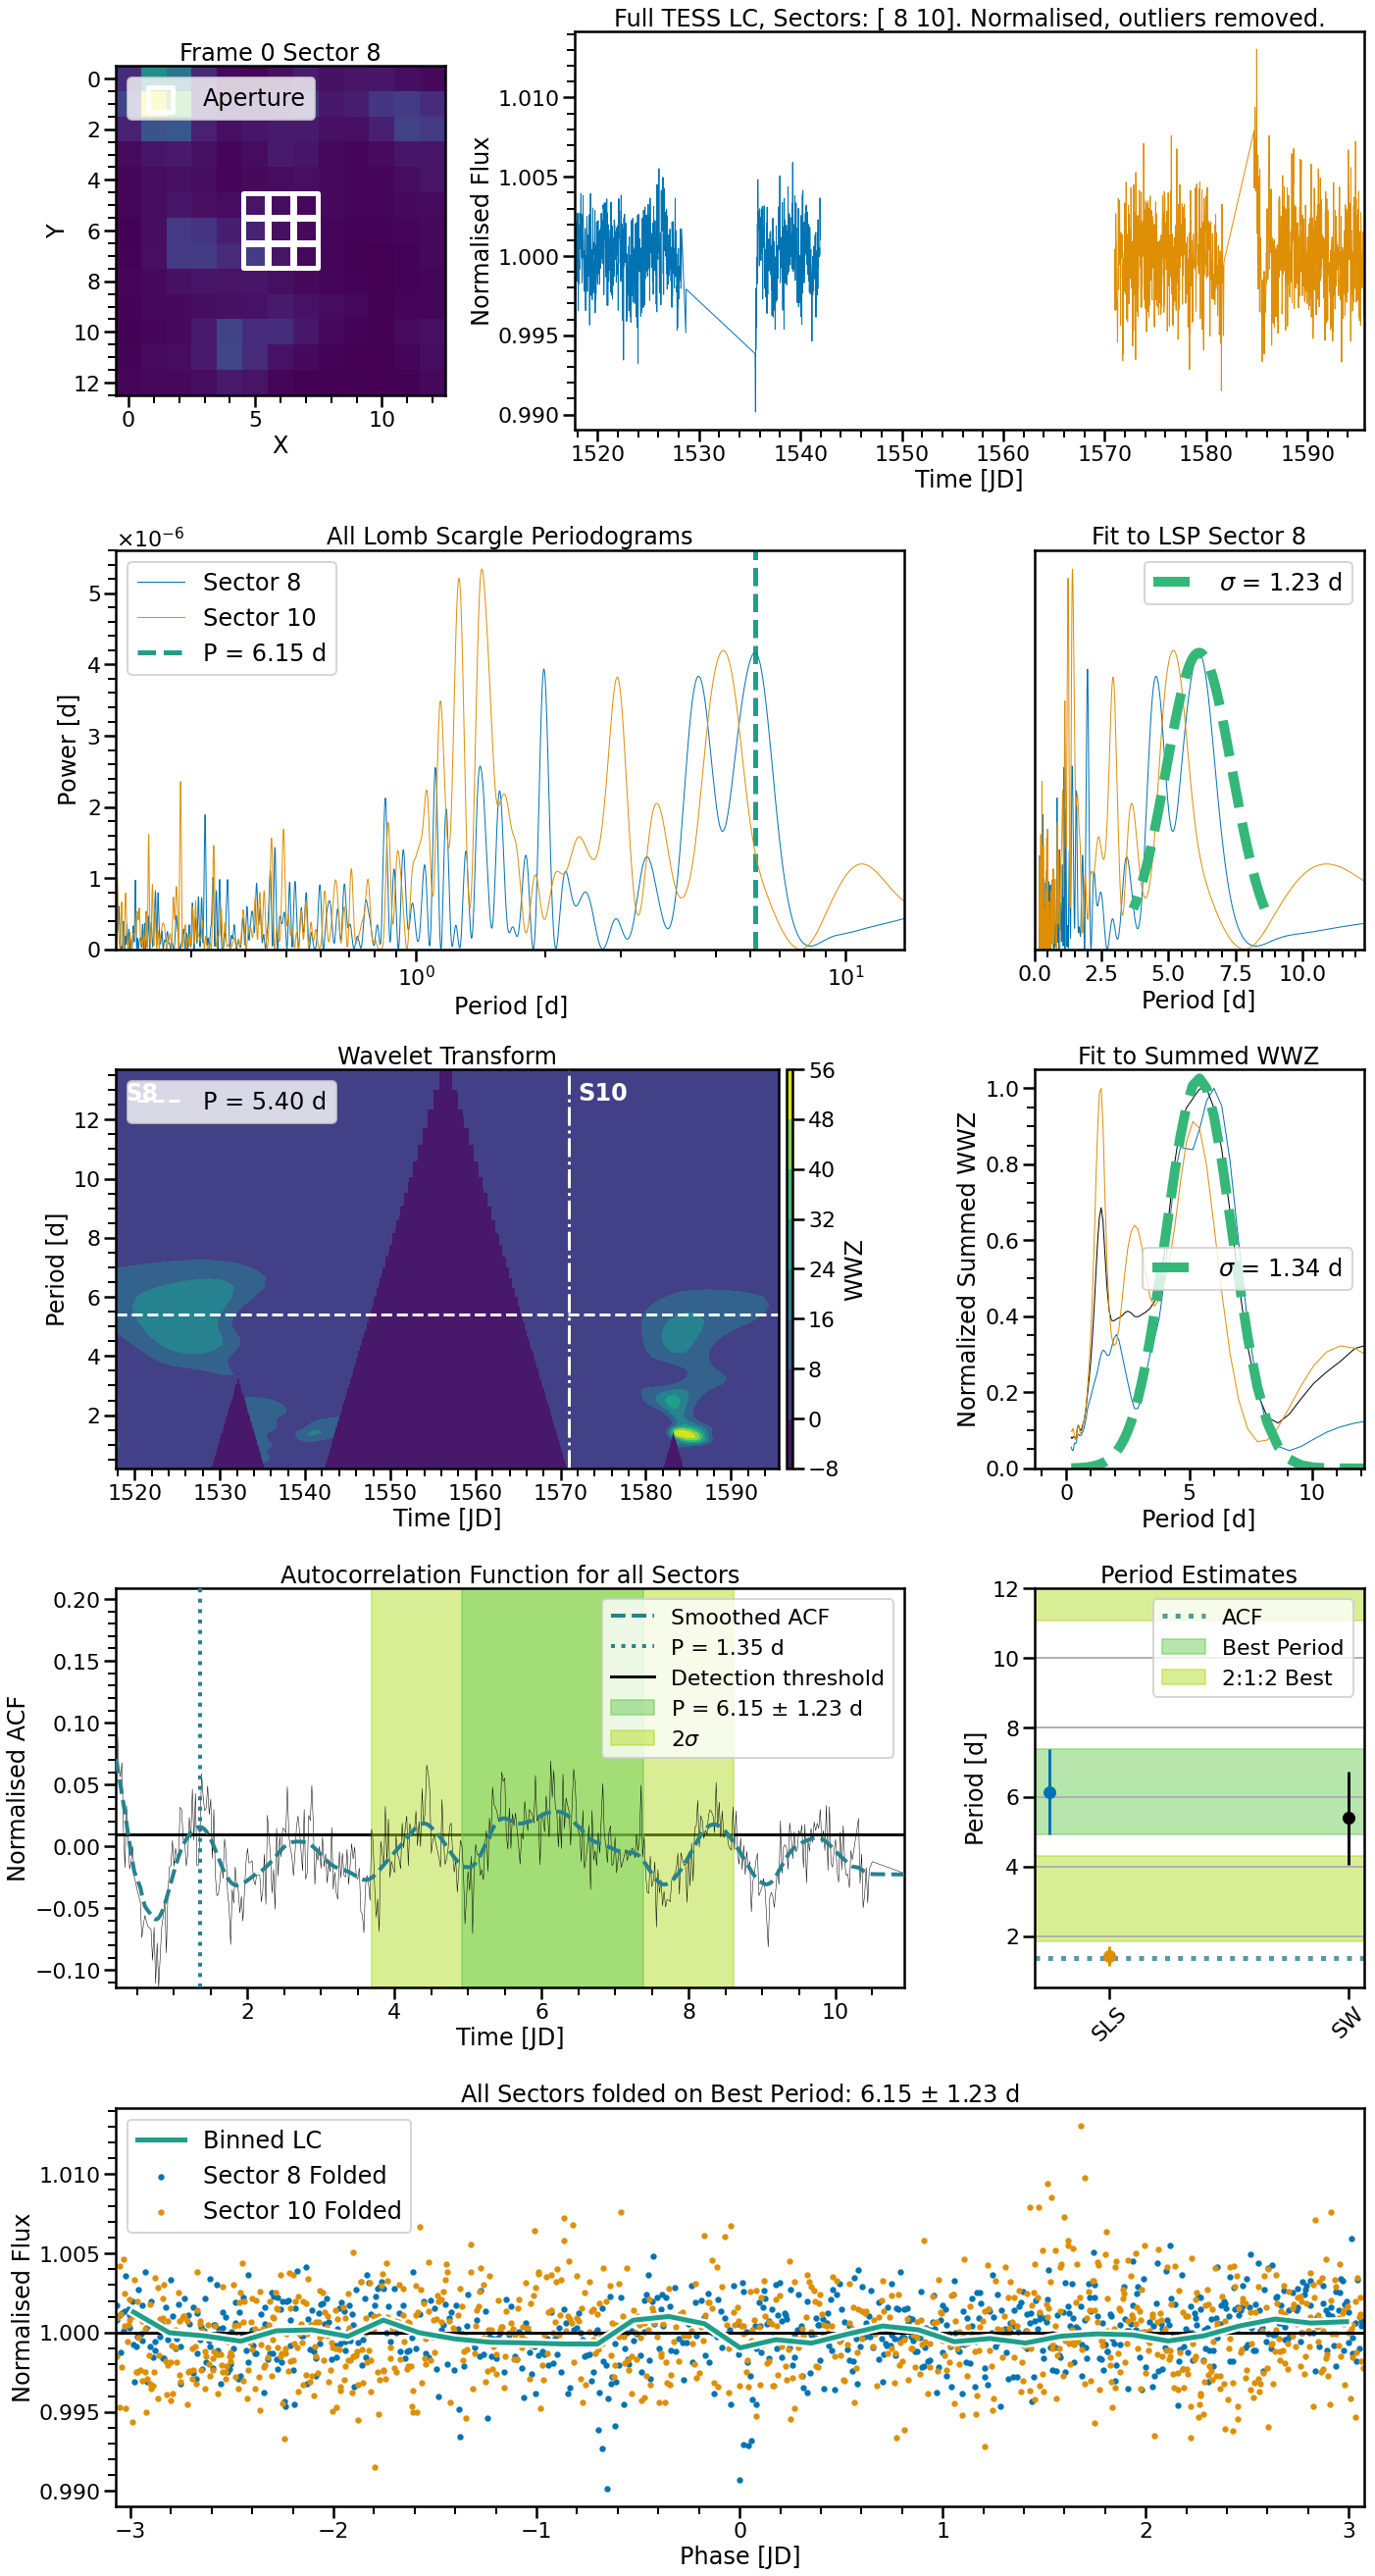

In [4]:
j.run()